In [3]:
# Import parking garage
from zarrtraj import *
import MDAnalysis as mda
import MDAnalysisData
import zarr
import h5py
import numcodecs
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
os.chdir('benchmark_files')



/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


importing zarrtraj...


In [4]:
# Setup yiip data
yiip = MDAnalysisData.yiip_equilibrium.fetch_yiip_equilibrium_short()
u = mda.Universe(yiip.topology, yiip.trajectory)
positions = mda.Universe(yiip.topology, yiip.trajectory, in_memory=True).trajectory.get_array()

print(np.max(positions))

YiiP_system.pdb: 0.00B [00:00, ?B/s]

YiiP_system.pdb: 8.84MB [00:03, 2.88MB/s]                            
YiiP_system_9ns_center.xtc: 373MB [00:22, 16.2MB/s]                               
/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element Z found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element D found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}"

135.99


In [4]:
# Convenience methods

def generate_traj(n_atoms):
    frames = 100
    # Generate positions array using min and max position value from yiip_equilibrium
    pos = (135.99 + 35.31) * np.random.random_sample((frames, n_atoms, 3)) - 35.31
    pos = pos.astype('float32')
    return pos

def filesize(filename):
    return int(subprocess.check_output(['du','-s', filename]).split()[0].decode('utf-8'))

def exponential_range(start, stop, step):
    return [pow(10, i) for i in range(start, stop, step)]


    


In [20]:
filters = [numcodecs.Quantize(digits=6, dtype='i4')]
compressor = numcodecs.Blosc(cname='zstd', clevel=9)
compressor2 = numcodecs.Blosc(cname='zstd', clevel=0)

for i in range(3, 8):
    n_atoms = pow(10, i)
    traj = generate_traj(n_atoms)
    u = mda.Universe(traj)

    z1 = zarr.open_group(f"10e{i}_zarr_c_f.zarr", mode='w')
    z2 = zarr.open_group(f"10e{i}_zarr_un_f.zarr", mode='w')
    z3 = zarr.open_group(f"10e{i}_zarr_c.zarr", mode='w')
    z4 = zarr.open_group(f"10e{i}_zarr_un.zarr", mode= 'w')

    with mda.Writer(z1, n_atoms, format='ZARRTRAJ', mode='w', compressor=compressor, filters=filters) as w:
        for ts in u.trajectory:
            w.write(u.atoms)

    with mda.Writer(z2, n_atoms, format='ZARRTRAJ', mode='w', compressor=compressor2, filters=filters) as w:
        for ts in u.trajectory:
            w.write(u.atoms)

    with mda.Writer(z3, n_atoms, format='ZARRTRAJ', mode='w', compressor=compressor) as w:
        for ts in u.trajectory:
            w.write(u.atoms)

    with mda.Writer(z4, n_atoms, format='ZARRTRAJ', mode='w', compressor=compressor2) as w:
        for ts in u.trajectory:
            w.write(u.atoms)
"""
    with mda.Writer(f"10e{i}_xtc.xtc", n_atoms) as w:
        for ts in u.trajectory:
            w.write(u.atoms)

    with mda.Writer(f"10e{i}_trr.trr", n_atoms) as w:
        for ts in u.trajectory:
            w.write(u.atoms)   
    
    with mda.Writer(f"10e{i}_h5md_c.h5md", n_atoms, compression='gzip', compression_opts=9, convert_units=False) as w:
        for ts in u.trajectory:
            w.write(u.atoms)   

    with mda.Writer(f"10e{i}_h5md_un.h5md", n_atoms, convert_units=False) as w:
        for ts in u.trajectory:
            w.write(u.atoms)   

"""
    

ValueError: only floating point data types are supported

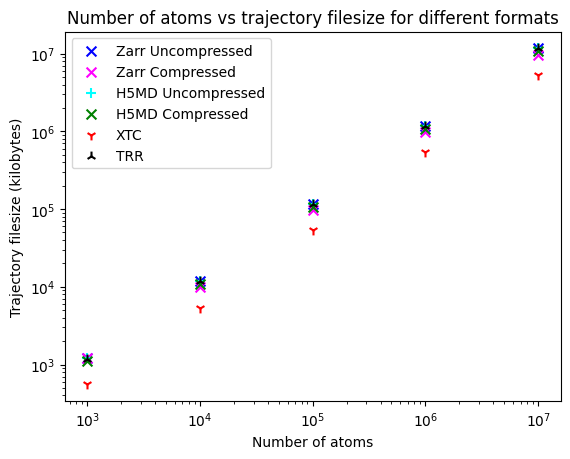

In [24]:
n = np.logspace(3, 7, 5)

x_filesize = []
t_filesize = []
z_filesize = []
z_c_filesize = []
h_filesize =[]
h_c_filesize =[]

for i in range(3, 8, 1):
    x_filesize.append(filesize(f'10e{i}_xtc.xtc'))
    t_filesize.append(filesize(f'10e{i}_trr.trr'))
    z_filesize.append(filesize(f'10e{i}_zarr_un.zarr'))
    z_c_filesize.append(filesize(f'10e{i}_zarr_c.zarr'))
    h_filesize.append(filesize(f'10e{i}_h5md_un.h5md'))
    h_c_filesize.append(filesize(f'10e{i}_h5md_c.h5md'))


# Graph zarrtraj size vs h5 size
plt.title('Number of atoms vs trajectory filesize for different formats')
plt.xlabel('Number of atoms')
plt.ylabel('Trajectory filesize (kilobytes)')
plt.xscale('log')
plt.yscale('log')

plt.scatter(n, z_filesize, c='blue', s=50, label="Zarr Uncompressed", marker='x')
plt.scatter(n, z_c_filesize, c='magenta', s=50, label="Zarr Compressed", marker='x')
plt.scatter(n, h_filesize, c='cyan', s=50, label="H5MD Uncompressed", marker='+')
plt.scatter(n, h_c_filesize, c='green', s=50, label="H5MD Compressed", marker='x')
plt.scatter(n, x_filesize, c='red', s=50, label="XTC", marker='1')
plt.scatter(n, t_filesize, c='black', s=50, label="TRR", marker='2')

plt.legend()



In [ ]:
n = n.astype('int')
n_atoms = np.tile(n, 6)
formats = ['Zarr compressed' for _ in range(5)] + ['Zarr uncompressed' for _ in range(5)] + ['H5MD compressed' for _ in range(5)] + ['H5MD uncompressed' for _ in range(5)] + ['XTC' for _ in range(5)] + ['TRR' for _ in range(5)]
fsizes = z_c_filesize + z_filesize + h_c_filesize + h_filesize + x_filesize + t_filesize

data = {'Format' : formats, 'Number of atoms' : n_atoms, 'Filesize (kilobyte)' : fsizes} 
df = pd.DataFrame(data)

# Displaying the table
print(df)

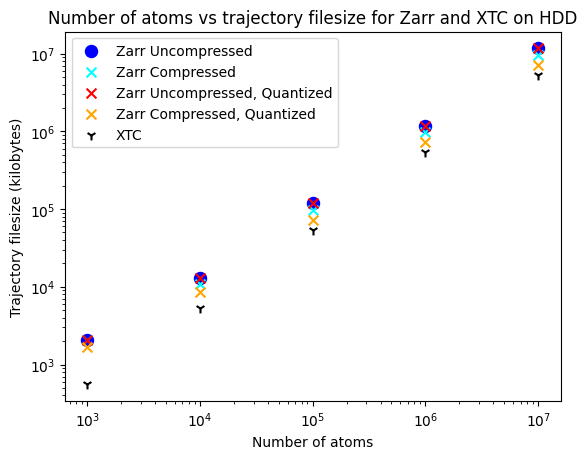

In [21]:
# Testing quantize filter

n = np.logspace(3, 7, 5)

x_filesize = []
z_f_filesize = []
z_c_f_filesize = []
z_filesize = []
z_c_filesize = []


for i in range(3, 8, 1):
    x_filesize.append(filesize(f'10e{i}_xtc.xtc'))
    z_filesize.append(filesize(f'10e{i}_zarr_un.zarr'))
    z_c_filesize.append(filesize(f'10e{i}_zarr_c.zarr'))
    z_f_filesize.append(filesize(f'10e{i}_zarr_un_f.zarr'))
    z_c_f_filesize.append(filesize(f'10e{i}_zarr_c_f.zarr'))

# Graph zarrtraj size vs h5 size
plt.title('Number of atoms vs trajectory filesize for Zarr and XTC on HDD')
plt.xlabel('Number of atoms')
plt.ylabel('Trajectory filesize (kilobytes)')
plt.xscale('log')
plt.yscale('log')

plt.scatter(n, z_filesize, c='blue', s=75, label="Zarr Uncompressed", marker='o')
plt.scatter(n, z_c_filesize, c='cyan', s=50, label="Zarr Compressed", marker='x')
plt.scatter(n, z_f_filesize, c='red', s=50, label="Zarr Uncompressed, Quantized", marker='x')
plt.scatter(n, z_c_f_filesize, c='orange', s=50, label="Zarr Compressed, Quantized", marker='x')
plt.scatter(n, x_filesize, c='black', s=50, label="XTC", marker='1')


plt.legend()


In [27]:
# YIIP size and iteration time tests
compressor = numcodecs.Blosc(cname='zstd', clevel=9)
compressor2 = numcodecs.Blosc(cname='zstd', clevel=0)

u = mda.Universe(yiip.topology, yiip.trajectory)

with mda.Writer(f"yiip_xtc.xtc", n_atoms) as w:
    for ts in u.trajectory:
        w.write(u)

with mda.Writer(f"yiip_trr.trr", n_atoms) as w:
    for ts in u.trajectory:
        w.write(u)   

with mda.Writer(f"yiip_h5md_c.h5md", n_atoms, compression='gzip', compression_opts=9, convert_units=False) as w:
    for ts in u.trajectory:
        w.write(u)   

with mda.Writer(f"yiip_h5md_un.h5md", n_atoms, convert_units=False) as w:
    for ts in u.trajectory:
        w.write(u)   

root = zarr.open(f"yiip_zarr_c.zarr", mode='w')
root.create_dataset('positions', data=positions, 
                    chunks = (1, n_atoms, 3), 
                    compressor=compressor)

root2 = zarr.open(f"yiip_zarr_un.zarr", mode='w')
root2.create_dataset('positions', data=positions, 
                    chunks = (1, n_atoms, 3), 
                    compressor=compressor2)

/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element Z found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element D found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to gu

TypeError: only length-1 arrays can be converted to Python scalars

In [16]:
filters = [numcodecs.Quantize(digits=3, dtype='f4')]

z = zarr.open_group('test.zarr', 'w')
z.require_dataset('test', 10, filters=filters)
z['test'] = np.random.random_sample(10)

z2 = zarr.open_group('test2.zarr', 'w')
z2.require_dataset('test', 10)
z2['test'] = np.random.random_sample(10)



In [18]:
for i in range(3, 8):
    n_atoms = pow(10, i)
    traj = generate_traj(n_atoms)
    print(traj[0][0])
    for i in range(traj.shape[2]):
        traj[:, :, i] *= 1000
    traj = traj.astype('i')
    print(traj[0][0])

[ 32.45393   52.221672 121.138695]
[ 32453  52221 121138]
[ 29.723679 134.0101    63.78008 ]
[ 29723 134010  63780]
[133.78802   64.78357  110.687935]
[133788  64783 110687]


KeyboardInterrupt: 